In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score

from src.data.gamma.structural_arxiv import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency

In [9]:
dataset_name = 'ogbn-arxiv'
folder = f'data/scored_omega/{dataset_name}'

In [5]:
dataset = load_dataset()

In [6]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(
    dataset, device='cpu'
)


In [10]:
os.listdir(folder)

['positional_node2vec.csv',
 'positional_graph_sage.csv',
 'structural_mlp.csv',
 'structural_omega_gcn_cossim.csv',
 'structural_omega_graph_sage_cossim.csv',
 'structural_omega_gat_cossim.csv']

In [32]:
model_parameters = [
    {
        'model_name': "$\Omega_{s}^{MLP}$",
        'file': 'structural_mlp.csv'
    },
    {
        'model_name': "$\Omega_{s}^{GraphSage}$",
        'file': 'structural_omega_graph_sage_cossim.csv'
    },
    {
        'model_name': "$\Omega_{s}^{GCN}$",
        'file': 'structural_omega_gcn_cossim.csv'
    },
    {
        'model_name': "$\Omega_{s}^{GAT}$",
        'file': 'structural_omega_gat_cossim.csv'
    },
    {
        'model_name': "$\Omega_{p}^{GraphSage}$",
        'file': 'positional_graph_sage.csv'
    },
    {
        'model_name': "$\Omega_{p}^{Node2Vec}$",
        'file': 'positional_node2vec.csv'
    }
]

In [33]:
file = model_parameters[0]['file']
scores = pd.read_csv(f'{folder}/{file}').set_index(['source', 'target'])['omega_pred']
scores

source  target
104447  13091     0.586956
15858   47283     0.641920
107156  69161     0.352049
        136440    0.341153
        107366    0.297747
                    ...   
45118   79124     0.886106
        147994    0.742534
        162473    0.756534
        162537    0.708751
        72717     0.539122
Name: omega_pred, Length: 1166243, dtype: float64

In [34]:
edges_test[:, :5]

tensor([[105794,  75620, 138895, 133642, 144254],
        [142957,  59683,  59683, 115102,  59326]])

In [35]:
test_scores = scores[edges_test.numpy().T.tolist()]
test_scores.head()

source  target
105794  142957    0.565479
75620   59683     0.585126
138895  59683     0.529595
133642  115102    0.488394
144254  59326     0.674076
Name: omega_pred, dtype: float64

In [123]:
series_list = []
for model_dict in model_parameters:
    model_name = model_dict['model_name']
    file = model_dict['file']
    preds = (
        pd.read_csv(f'{folder}/{file}')
        .set_index(['source', 'target'])['omega_pred']
        .rename(model_name)
    )
    test_preds = preds[edges_test.numpy().T.tolist()]
    series_list.append(test_preds)

test_preds = pd.DataFrame(series_list).T
test_preds.head()

,,$\Omega_{s}^{MLP}$,$\Omega_{s}^{GraphSage}$,$\Omega_{s}^{GCN}$,$\Omega_{s}^{GAT}$,$\Omega_{p}^{GraphSage}$,$\Omega_{p}^{Node2Vec}$
source,target,,,,,,
105794,142957,0.565479,0.889694,0.901015,0.911929,0.700079,0.690346
75620,59683,0.585126,0.735009,0.915940,0.902966,0.662867,0.674190
138895,59683,0.529595,0.834004,0.909675,0.921977,0.618921,0.641028
133642,115102,0.488394,0.585439,0.691818,0.785906,0.711059,0.669982
144254,59326,0.674076,0.703309,0.892085,0.836083,0.738485,0.708185


In [124]:
test_preds.corr().style.background_gradient()

,$\Omega_{s}^{MLP}$,$\Omega_{s}^{GraphSage}$,$\Omega_{s}^{GCN}$,$\Omega_{s}^{GAT}$,$\Omega_{p}^{GraphSage}$,$\Omega_{p}^{Node2Vec}$
$\Omega_{s}^{MLP}$,1.000000,0.400405,0.382868,0.362428,0.171635,0.171017
$\Omega_{s}^{GraphSage}$,0.400405,1.000000,0.772815,0.759573,0.282441,0.376843
$\Omega_{s}^{GCN}$,0.382868,0.772815,1.000000,0.815919,0.306356,0.422731
$\Omega_{s}^{GAT}$,0.362428,0.759573,0.815919,1.000000,0.310992,0.403329
$\Omega_{p}^{GraphSage}$,0.171635,0.282441,0.306356,0.310992,1.000000,0.374156
$\Omega_{p}^{Node2Vec}$,0.171017,0.376843,0.422731,0.403329,0.374156,1.000000


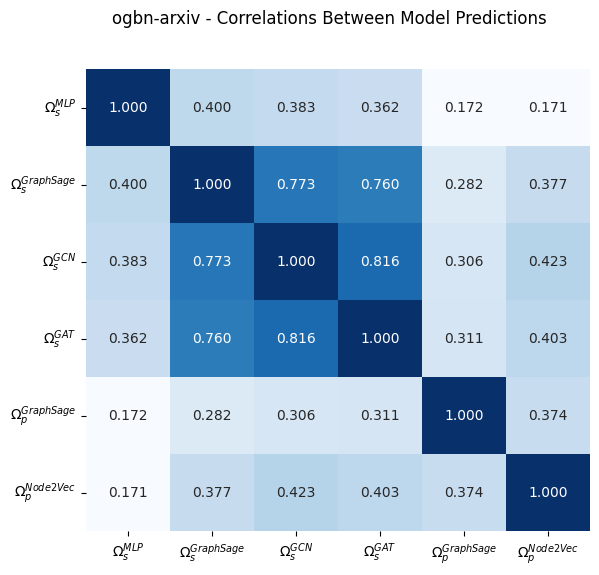

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 6))

fig.suptitle('ogbn-arxiv - Correlations Between Model Predictions')

sns.heatmap(
    test_preds.corr(),
    cmap='Blues',
    annot=True,
    cbar=False,
    fmt='.3f',
    ax=ax
)

ax.tick_params(axis='y', rotation=0)

plt.savefig('reports/images/ogbn-arxiv/correlation_matrix_test.pdf')

In [126]:
test_preds['theta'] = (data.y[edges_test[0]] == data.y[edges_test[1]] * 1).numpy().squeeze()

In [127]:
auc_dict = {}
for p in np.linspace(0, 1, 51):
    score = test_preds[r'$\Omega_{p}^{GraphSage}$'].mul(p).add(
        test_preds[r'$\Omega_{s}^{GCN}$'].mul(1-p))
    auc = roc_auc_score(test_preds['theta'], score)
    auc_dict[p] = auc


In [128]:
pd.Series(auc_dict).idxmax()

0.1

Text(0.5, 1.0, 'ROC-AUC of ensemble: $p\\Omega_{p}^{GraphSage} + (1-p)\\Omega_{s}^{GCN}$')

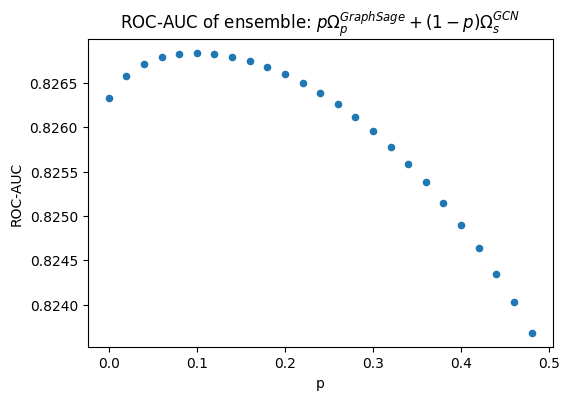

In [129]:
(
    pd.Series(auc_dict)
    .rename('ROC-AUC')
    .rename_axis('p')
    .to_frame()
    .query('p < 0.5')
    .reset_index()
    .plot(kind='scatter', x='p', y='ROC-AUC', figsize=(6, 4))
)


plt.title('ROC-AUC of ensemble: $p\Omega_{p}^{GraphSage} + (1-p)\Omega_{s}^{GCN}$')

In [130]:
auc_df = (
    pd.Series(auc_dict)
    .rename('ROC-AUC')
    .rename_axis('p')
    .to_frame()
    .query('p < 0.5')
    .reset_index()
    .query('p < 0.5')
)

In [131]:
auc_df['ROC-AUC'].max()

0.8268410792472933

In [132]:
auc_df['ROC-AUC'].iloc[0]

0.8263290641863809

In [136]:
(
    pd.Series(auc_dict)
    .rename('ROC-AUC')
    .rename_axis('p')
    .to_frame()
)

,ROC-AUC
p,
0.00,0.826329
0.02,0.826574
0.04,0.826710
0.06,0.826789
0.08,0.826829
0.10,0.826841
0.12,0.826829
0.14,0.826797
0.16,0.826747


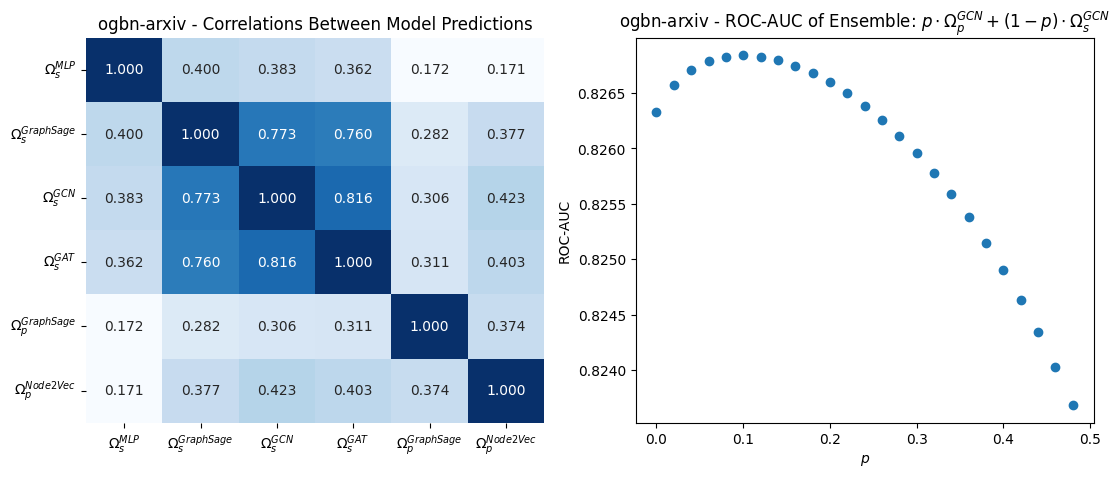

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.set_title('ogbn-arxiv - Correlations Between Model Predictions')

sns.heatmap(
    test_preds.drop(columns=['theta']).corr(),
    cmap='Blues',
    annot=True,
    cbar=False,
    fmt='.3f',
    ax=ax1
)

ax1.tick_params(axis='y', rotation=0)


ax2.scatter(auc_df['p'], auc_df['ROC-AUC'])
ax2.set_ylabel('ROC-AUC')
ax2.set_xlabel('$p$')

ax2.set_title('ogbn-arxiv - ROC-AUC of Ensemble: $p \cdot \Omega_{p}^{GCN} + (1-p)\cdot\Omega_{s}^{GCN}$')
plt.savefig('reports/images/ogbn-arxiv/correlation_matrix_auc_ensemble.pdf')